In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import scipy.io as sci

from sklearn.model_selection import train_test_split
from functools import partial

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


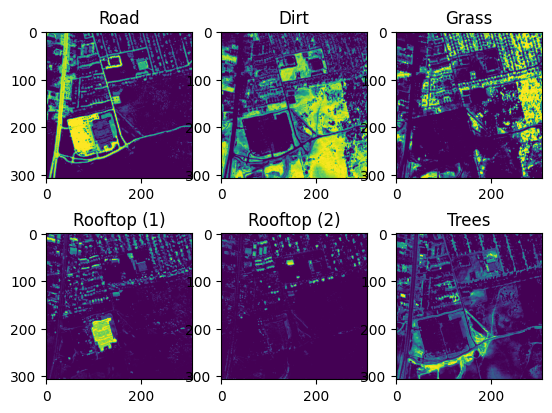

In [3]:
data = sci.loadmat('/content/drive/MyDrive/IMA206/Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat('/content/drive/MyDrive/IMA206/end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure()
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
names = ['Road','Dirt','Grass','Rooftop (1)','Rooftop (2)','Trees']
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    plt.title(names[ii])


(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x7f96c98cc8b0>])

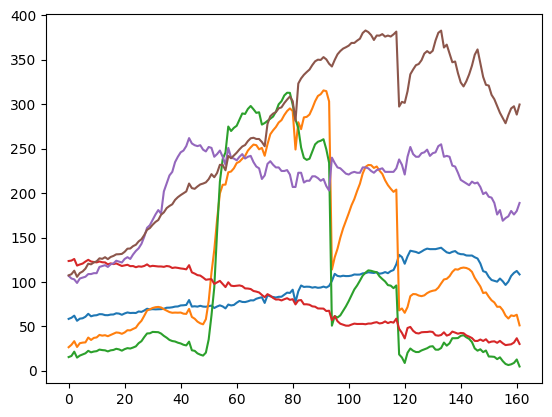

In [4]:
endmembers= np.zeros((162,6))

for ii in range(6): 
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure(),plt.plot(endmembers)

In [5]:
X2 = np.zeros((nCol+1, nRow+1, 162))
X2[:-1, :-1] = X.T.reshape((nCol, nRow, -1))
X2[-1, :], X2[:, -1] = 0, 0
X2.shape

(308, 308, 162)

In [6]:
n, m = nCol+1, nRow+1
r_channels = 6
conv_channels = 256
nIter = 3000
learning_rate = 0.001

E = endmembers.T
Y = X2.reshape(n*m, 162)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [16,32,64,128]
decoder_channels = [128,64,32,r_channels]

# Define the network architecture
class Undip_net(nn.Module):
  def __init__(self):
    super(Undip_net, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), # (308,308)
                                  nn.MaxPool2d(1, stride=2, padding=0), # (154,154)
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
                                  nn.MaxPool2d(1, stride=2, padding=0), # (77,77)
    )
    
    self.encoder3 = nn.Sequential(nn.Conv2d(encoder_channels[1], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[2]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
                                  #nn.MaxPool2d(1, stride=2, padding=0),
    )
    
    
    self.encoder4 = nn.Sequential(nn.Conv2d(encoder_channels[2], encoder_channels[3], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[3]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
                                  #nn.MaxPool2d(1, stride=2, padding=0),
    )
    
    
    self.base_conv = nn.Sequential(nn.Conv2d(encoder_channels[3], decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                   nn.BatchNorm2d(decoder_channels[0]),
                                   nn.LeakyReLU(inplace=True), # (77,77)
    )
    
    self.decoder1 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )


    self.skip1 = nn.Sequential(nn.Conv2d(encoder_channels[2], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[2]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[2], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[2]),
                               nn.LeakyReLU(inplace=True),
    )
    
    self.decoder2 = nn.Sequential(nn.Conv2d(encoder_channels[2]+decoder_channels[0], decoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )

    self.skip2 = nn.Sequential(nn.Conv2d(encoder_channels[1], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[1]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[1], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[1]),
                               nn.LeakyReLU(inplace=True),
    )
    
    self.decoder3 = nn.Sequential(nn.ConvTranspose2d(encoder_channels[1]+decoder_channels[1], decoder_channels[2], (4, 4), stride=(2, 2), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[2]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
    )

    self.skip3 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[0]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[0], encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[0]),
                               nn.LeakyReLU(inplace=True)
    )
    
    self.decoder4 = nn.Sequential(nn.ConvTranspose2d(encoder_channels[0]+decoder_channels[2], decoder_channels[3], (4, 4), stride=(2, 2), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[3]),
                                  nn.Softmax(), # (307,307)
    )




  def forward(self, input):
    
    
    features = []
    
    current_feature = self.encoder1(input)
    features.append(current_feature)
    
    current_feature = self.encoder2(current_feature)
    features.append(current_feature)
    
    current_feature = self.encoder3(current_feature)
    features.append(current_feature)
    
    current_feature = self.encoder4(current_feature)
    #features.append(current_feature)
    
    current_feature = self.base_conv(current_feature)
    
    current_feature = self.decoder1(current_feature)
    
    features[2] = self.skip1(features[2])
    current_feature = torch.cat((current_feature,features[2]), dim=1)
    current_feature = self.decoder2(current_feature)
    
    features[1] = self.skip2(features[1])
    current_feature = torch.cat((current_feature,features[1]), dim=1)
    current_feature = self.decoder3(current_feature)

    features[0] = self.skip3(features[0])
    current_feature = torch.cat((current_feature,features[0]), dim=1)
    output = self.decoder4(current_feature)

      
      
    return output



def train(model, input, end_member_estimation, gt_fractional_abundance, epochs=1000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  model = model.to(device)
  criterion = criterion.to(device)


  
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input).double()
    loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    print('current loss ', loss.item())
    
    loss.backward()
    optimizer.step()


  return model



In [ ]:
A = torch.normal(0,1,size=(1,r_channels,n,m))

In [ ]:
Undip_model = Undip_net()
# the training command
train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y))

<ipython-input-72-e2e8d3e73c0c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y))


current loss  14247.404951428773
current loss  18625.02089078748
current loss  13467.160371577125
current loss  11324.197599595764
current loss  10706.86837601237
current loss  10485.462516533982
current loss  10388.789066493662
current loss  10327.65860094466
current loss  10285.15116070542
current loss  10252.823763124088
current loss  10221.611165112277
current loss  10191.341936561936
current loss  10161.792037944946
current loss  10133.005845908248
current loss  10105.856634778687
current loss  10080.498790905885
current loss  10056.395927777066
current loss  10032.959686422988
current loss  10010.155796321802
current loss  9988.476243893663
current loss  9968.856736145306
current loss  9952.4220228331
current loss  9939.575353631826
current loss  9929.638840920281
current loss  9921.40979454736
current loss  9913.943660396839
current loss  9906.438467006705
current loss  9898.272204412699
current loss  9889.203754658693
current loss  9879.432984804573
current loss  9869.390755694

Undip_net(
  (encoder1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=

In [ ]:
train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.002)

<ipython-input-74-ca1e11df9414>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.002)


current loss  1419.9218342353556
current loss  3457.8774112896303
current loss  1681.0263218013786
current loss  1883.6166389785
current loss  2371.1442918436296
current loss  2103.0569934535497
current loss  1716.2964356381058
current loss  1604.5705780887995
current loss  1707.4174377238185
current loss  1800.2414390670244
current loss  1761.1739681625008
current loss  1644.3994458457446
current loss  1564.014021057908
current loss  1559.9539143686584
current loss  1583.8274668072686
current loss  1581.9848293115308
current loss  1550.3646595637413
current loss  1518.0234799760087
current loss  1504.619489858721
current loss  1504.147694444679
current loss  1500.2855425546354
current loss  1486.438622182569
current loss  1470.8283008949818
current loss  1463.350469609898
current loss  1462.5569522831129
current loss  1459.764634283408
current loss  1451.5372947696458
current loss  1442.3277224707863
current loss  1437.1866056679596
current loss  1435.7709024554165
current loss  1433.

Undip_net(
  (encoder1): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=

In [ ]:
import os
torch.save(Undip_model.state_dict(), os.path.join('/content/drive/MyDrive/IMA206', 'undip1.pt'))

In [ ]:
A_ = Undip_model(torch.tensor(A))

<ipython-input-76-c34782ed781c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_ = Undip_model(torch.tensor(A))
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)


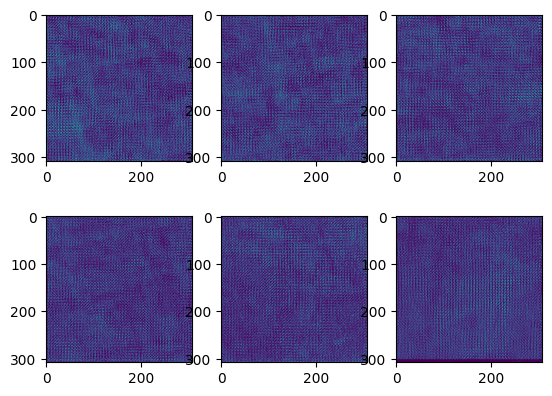

In [ ]:
for ii in range(6): 
  ax = plt.subplot(2, 3, ii+1)
  im = A_.detach().numpy()
  print(im.shape)
  im = im[0,ii,:,:]
  print(im.shape)
  ax.imshow((im-np.mean(im))/np.std(im))

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [256,256]
decoder_channels = [256,256,r_channels]
skip_channels = 4

# Define the network architecture
class Undip_net_paper(nn.Module):
  def __init__(self):
    super(Undip_net_paper, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), stride=(2, 2), padding=1, dilation=1), # (308,308) to (154,154)
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), 
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')


    self.skip = nn.Sequential(nn.Conv2d(r_channels, skip_channels, (1, 1), stride=(1, 1), padding=0, dilation=1),
                              nn.BatchNorm2d(skip_channels),
                              nn.LeakyReLU(inplace=True),
    )
    
    
    
    self.decoder1 = nn.Sequential(nn.BatchNorm2d(encoder_channels[1]+skip_channels),
                                  nn.Conv2d(encoder_channels[1]+skip_channels, decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True)
    )


   
    self.decoder2 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )

    self.decoder3 = nn.Sequential(nn.Conv2d(decoder_channels[1], decoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.Softmax()
    )


  def forward(self, input):
    
        
    current_feature = self.encoder1(input)
    current_feature = self.encoder2(current_feature)
    current_feature = self.upsample(current_feature)
    
    current_skip_output = self.skip(input)

    current_feature = torch.cat((current_feature,current_skip_output), dim=1)
    
    
    current_feature = self.decoder1(current_feature)
    current_feature = self.decoder2(current_feature)
    output = self.decoder3(current_feature)
    
      
    return output



def train(model, input, end_member_estimation, gt_fractional_abundance, epochs=2000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



  model = model.to(device)
  input = input.to(device)
  criterion = criterion.to(device)
  end_member_estimation = end_member_estimation.to(device)
  gt_fractional_abundance = gt_fractional_abundance.to(device)


  
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input).double()
    loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    print('current loss ', loss.item())
    
    loss.backward()
    optimizer.step()


  return model



In [22]:
A = torch.normal(0,1,size=(1,r_channels,n,m))

In [23]:
Undip_model = Undip_net_paper()
# the training command
train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.001, epochs=3000)

<ipython-input-23-63f567bd9cbe>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.001, epochs=3000)


current loss  11124.55947577958
current loss  20970.479477826608
current loss  14661.055816568158
current loss  14261.10819162401
current loss  15531.716531712871
current loss  14730.418993095544
current loss  14022.429345280083
current loss  12360.470994424119
current loss  12151.699667296176
current loss  12119.739890694993
current loss  11377.71769730131
current loss  11236.001622111615
current loss  11077.327438139226
current loss  10884.081710813409
current loss  10751.747254243423
current loss  10636.786971543013
current loss  10405.259609282513
current loss  10316.629995911844
current loss  10267.761366495955
current loss  10081.79965423879
current loss  9901.87213609616
current loss  9821.862917615772
current loss  9761.50455067016
current loss  9637.876383219786
current loss  9542.71481594909
current loss  9487.305911512913
current loss  9427.70200600883
current loss  9353.637854406656
current loss  9258.696088306702
current loss  9157.36229111039
current loss  9052.1084617912

Undip_net_paper(
  (encoder1): Sequential(
    (0): Conv2d(6, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (skip): Sequential(
    (0): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (decoder1): Sequential(
    (0): BatchNorm2d(260, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(260, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2)

In [24]:
A_ = Undip_model(torch.tensor(A).to(device))

<ipython-input-24-4b65992dc1e2>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_ = Undip_model(torch.tensor(A).to(device))


(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)
(1, 6, 308, 308)
(308, 308)


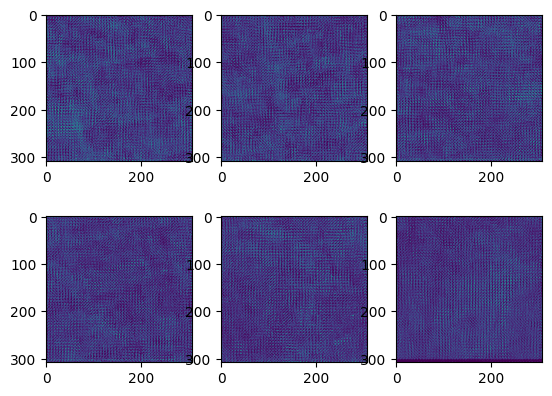

In [25]:
for ii in range(6): 
  ax = plt.subplot(2, 3, ii+1)
  im = A_.cpu().detach().numpy()
  print(im.shape)
  im = im[0,ii,:,:]
  print(im.shape)
  ax.imshow((im-np.mean(im))/np.std(im))